# Análisis del Cambio Climático y Eventos Extremos

## 1. Introducción
El cambio climático es la alteración a largo plazo del clima, causada principalmente por actividades humanas. Sus efectos incluyen el aumento de temperaturas, fenómenos extremos y daños a ecosistemas. Analizarlo con datos es clave para entender su evolución, tomar decisiones informadas y diseñar soluciones efectivas.

## 2. Objetivos
- Consultar datos públicos de BigQuery sobre calidad del aire (OpenAQ).
- Analizar cambios en los últimos 3 años.
- Visualizar y comparar tendencias de contaminación.
- Obtener conclusiones útiles a partir del análisis.

## 3. Exploración de Datos
- Consulta a la base de datos pública `bigquery-public-data.openaq.global_air_quality`.
- Filtro temporal: últimos 3 años.
- Parámetros seleccionados: `pm25`, `pm10`, `o3`, etc.

## 4. Limpieza y Transformación
- Conversión de columnas de fechas.
- Filtrado por regiones o países (opcional).
- Revisión de valores nulos y formatos.

## 5. Visualización de Datos
- Gráfico 1: Mapa de calor geográfico (con `Folium` o `GeoPandas`).
- Gráfico 2: Comparación de PM10 vs PM2.5 en regiones seleccionadas.
- Gráfico 3: Tendencia temporal de PM2.5 global.
- Gráfico 4: Boxplot por país o región.
- Gráfico 5: Distribución por estación del año o mes.

## 6. Análisis e Interpretación
- ¿Qué tendencias se observan en los datos?
- ¿Ha mejorado o empeorado la calidad del aire?
- ¿Qué regiones presentan mayor contaminación?

## 7. Guardado y exportación
- Exportar resultados como `.csv` si es necesario.
- Guardar figuras con `plt.savefig(...)` si se incluyen en el repositorio.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.oauth2 import service_account
import folium
from folium.plugins import HeatMap
from datetime import datetime, timedelta
from branca.element import Template, MacroElement
from branca.colormap import linear
from IPython.display import HTML


ModuleNotFoundError: No module named 'google.cloud'

In [ ]:
credenciales = service_account.Credentials.from_service_account_file(
    "/Users/otymar/Downloads/mineria-de-datos-454019-cc0d5d8c0fe5.json"
)

# Crear cliente de BigQuery
cliente = bigquery.Client(credentials=credenciales, project=credenciales.project_id)


# Gráfico 1: Mapa de calor geográfico PM2.5

In [212]:
fecha_inicio = (datetime.utcnow() - timedelta(days=1095)).strftime("%Y-%m-%d")  # 3 años


consulta = """
SELECT city, location, timestamp, value, unit, pollutant, latitude, longitude
FROM `bigquery-public-data.openaq.global_air_quality`
WHERE pollutant IN ('pm25')
  AND value IS NOT NULL
  AND latitude IS NOT NULL
  AND longitude IS NOT NULL
LIMIT 100000
"""


resultado = cliente.query(consulta).result().to_dataframe()
print(resultado.shape)
print(resultado[["timestamp", "value", "latitude", "longitude"]].head())


/var/folders/l0/y6_kn2kj5ysb_90cx_wmwcvm0000gn/T/ipykernel_22785/1299993907.py:1: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  fecha_inicio = (datetime.utcnow() - timedelta(days=1095)).strftime("%Y-%m-%d")  # 3 años


(100000, 8)
                  timestamp      value  latitude  longitude
0 2022-05-03 11:00:00+00:00   8.880000       1.0  53.352778
1 2020-10-20 13:00:00+00:00  18.164000       1.0  42.659656
2 2022-04-30 06:00:00+00:00   3.083333       1.0  56.954847
3 2022-05-09 10:00:00+00:00  55.580000       1.0 -12.028694
4 2022-05-12 02:00:00+00:00  13.500000       1.0  45.698028


In [213]:
resultado = resultado.dropna(subset=["latitude", "longitude", "value"])
resultado = resultado[
    (resultado["latitude"].between(-90, 90)) &
    (resultado["longitude"].between(-180, 180))
]
resultado["value"] = pd.to_numeric(resultado["value"], errors="coerce")


In [214]:
# Coordenadas promedio como centro
center_lat = resultado["latitude"].mean()
center_lon = resultado["longitude"].mean()

# Crear mapa centrado
m = folium.Map(location=[center_lat, center_lon], zoom_start=2)

# Lista de datos para heatmap
heat_data = [[row["latitude"], row["longitude"], row["value"]] for index, row in resultado.iterrows()]

# Agregar capa HeatMap
HeatMap(heat_data, radius=30, blur=10, max_zoom=5).add_to(m)

# Agregar leyenda personalizada
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 40px;
    left: 40px;
    z-index:9999;
    background-color: rgba(255, 255, 255, 0.9);
    padding: 15px 20px;
    border: 1px solid #aaa;
    border-radius: 8px;
    font-size: 14px;
    box-shadow: 0 2px 8px rgba(0,0,0,0.3);
    line-height: 1.5;
">
    <div style="font-weight: bold; margin-bottom: 5px;">Contaminación<br>(PM2.5)</div>
    <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background: #0000ff; width: 18px; height: 18px; margin-right: 8px; opacity:0.7; border-radius: 3px;"></div>
        Muy baja
    </div>
    <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background: #00ffff; width: 18px; height: 18px; margin-right: 8px; opacity:0.7; border-radius: 3px;"></div>
        Baja
    </div>
    <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background: #ffff00; width: 18px; height: 18px; margin-right: 8px; opacity:0.7; border-radius: 3px;"></div>
        Media
    </div>
    <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background: #ff9900; width: 18px; height: 18px; margin-right: 8px; opacity:0.7; border-radius: 3px;"></div>
        Alta
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background: #ff0000; width: 18px; height: 18px; margin-right: 8px; opacity:0.7; border-radius: 3px;"></div>
        Muy Alta
    </div>
</div>
{% endmacro %}
"""


legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

# Guardar mapa
m.save("mapa_pm25_mundial_ultimo_anio.html")
m

# Gráfico 2: Comparación de PM2.5 y PM10 en 3 países

In [230]:
client = bigquery.Client()

# Consulta exploratoria
query = """
SELECT *
FROM `bigquery-public-data.openaq.global_air_quality`
LIMIT 5
"""

df_preview = client.query(query).to_dataframe()
print(df_preview.columns)
print(df_preview.head())


Index(['location', 'city', 'country', 'pollutant', 'value', 'timestamp',
       'unit', 'source_name', 'latitude', 'longitude',
       'averaged_over_in_hours', 'location_geom'],
      dtype='object')
                  location      city country pollutant    value  \
0   Borówiec, ul. Drapałka  Borówiec      PL        bc  0.85217   
1    Kraków, ul. Bulwarowa    Kraków      PL        bc  0.91284   
2          Płock, ul. Reja     Płock      PL        bc  1.41000   
3  Elbląg, ul. Bażyńskiego    Elbląg      PL        bc  0.33607   
4  Piastów, ul. Pułaskiego   Piastów      PL        bc  0.51000   

                  timestamp   unit source_name  latitude  longitude  \
0 2022-04-28 07:00:00+00:00  µg/m³        GIOS       1.0  52.276794   
1 2022-04-27 23:00:00+00:00  µg/m³        GIOS       1.0  50.069308   
2 2022-03-30 04:00:00+00:00  µg/m³        GIOS       1.0  52.550938   
3 2022-05-03 13:00:00+00:00  µg/m³        GIOS       1.0  54.167847   
4 2022-05-11 05:00:00+00:00  µg/m³       

In [418]:
# Cliente
client = bigquery.Client()

# Fechas
end_date = datetime.utcnow()
start_date = end_date - timedelta(days=3*365)

# Consulta funcional
query = f"""
SELECT
  country,
  city,
  location,
  pollutant AS parameter,
  value,
  unit,
  timestamp
FROM
  `bigquery-public-data.openaq.global_air_quality`
WHERE
  pollutant IN ('pm25', 'pm10', 'o3')
  AND country IN ('CL', 'FR', 'IN', 'US')
  AND timestamp BETWEEN TIMESTAMP('{start_date.strftime('%Y-%m-%d')}') AND TIMESTAMP('{end_date.strftime('%Y-%m-%d')}')
"""

df = client.query(query).to_dataframe()
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["year_month"] = df["timestamp"].dt.to_period("M").astype(str)

/var/folders/l0/y6_kn2kj5ysb_90cx_wmwcvm0000gn/T/ipykernel_22785/4093212517.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow()
/var/folders/l0/y6_kn2kj5ysb_90cx_wmwcvm0000gn/T/ipykernel_22785/4093212517.py:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["year_month"] = df["timestamp"].dt.to_period("M").astype(str)


In [419]:
# Agrupamos el valor promedio mensual por país y contaminante
grouped = (
    df.groupby(["country", "parameter", "year_month"])["value"]
    .mean()
    .reset_index()
    .pivot(index="year_month", columns=["country", "parameter"], values="value")
)

# Aseguramos que el índice esté ordenado
grouped = grouped.sort_index()
grouped.head()


country            CL                    FR                               IN  \
parameter        pm10       pm25         o3       pm10       pm25         o3   
year_month                                                                     
2022-03     59.668050  25.174905  58.289666  28.119922  17.070803  31.118680   
2022-04     56.141982  35.292523  67.833433  16.783678   9.548521  36.040466   
2022-05     63.448751  43.569982  68.405442  17.938803   8.681407  37.702713   

country                                   US                       
parameter         pm10        pm25        o3       pm10      pm25  
year_month                                                         
2022-03     196.447594  102.319886  0.036655  18.032462  6.396433  
2022-04     176.663959   74.545004  0.038432  28.161684  6.782856  
2022-05     142.189847   59.710238  0.035466  26.088782  6.082321

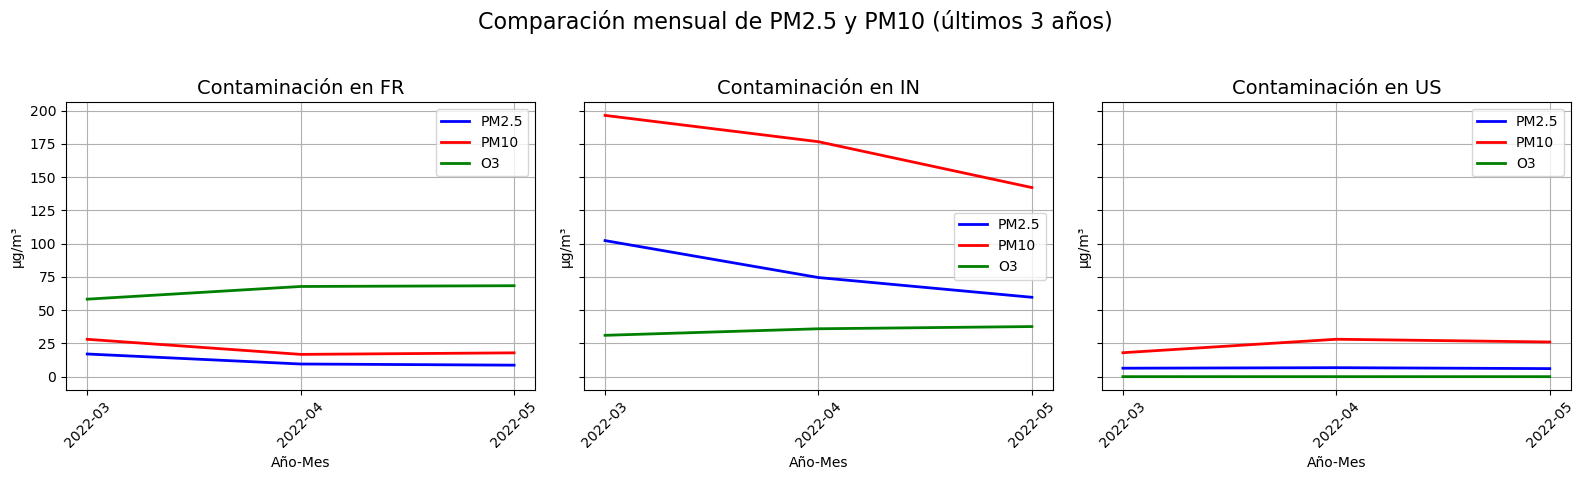

In [420]:
paises = ['FR', 'IN', 'US']
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)
axes = axes.flatten()

for i, pais in enumerate(paises):
    ax = axes[i]
    ax.plot(grouped.index, grouped[(pais, 'pm25')], label="PM2.5", color="blue", linewidth=2)
    ax.plot(grouped.index, grouped[(pais, 'pm10')], label="PM10", color="red", linewidth=2)
    ax.plot(grouped.index, grouped[(pais, 'o3')], label="O3", color="green", linewidth=2)
    ax.set_title(f"Contaminación en {pais}", fontsize=14)
    ax.set_xlabel("Año-Mes")
    ax.set_ylabel("µg/m³")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)
    ax.legend()

fig.suptitle("Comparación mensual de PM2.5 y PM10 (últimos 3 años)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Gráfico 3: Tendencia temporal de PM2.5

In [190]:
query = """
SELECT 
  country,
  city,
  location,
  pollutant,
  value,
  unit,
  timestamp
FROM 
  `bigquery-public-data.openaq.global_air_quality`
WHERE 
  pollutant = 'pm25'
  AND timestamp BETWEEN TIMESTAMP('2007-01-01') AND TIMESTAMP('2022-05-31')
"""


/var/folders/l0/y6_kn2kj5ysb_90cx_wmwcvm0000gn/T/ipykernel_22785/2312975737.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_pm25_global["year_month"] = df_pm25_global["timestamp"].dt.to_period("M").astype(str)


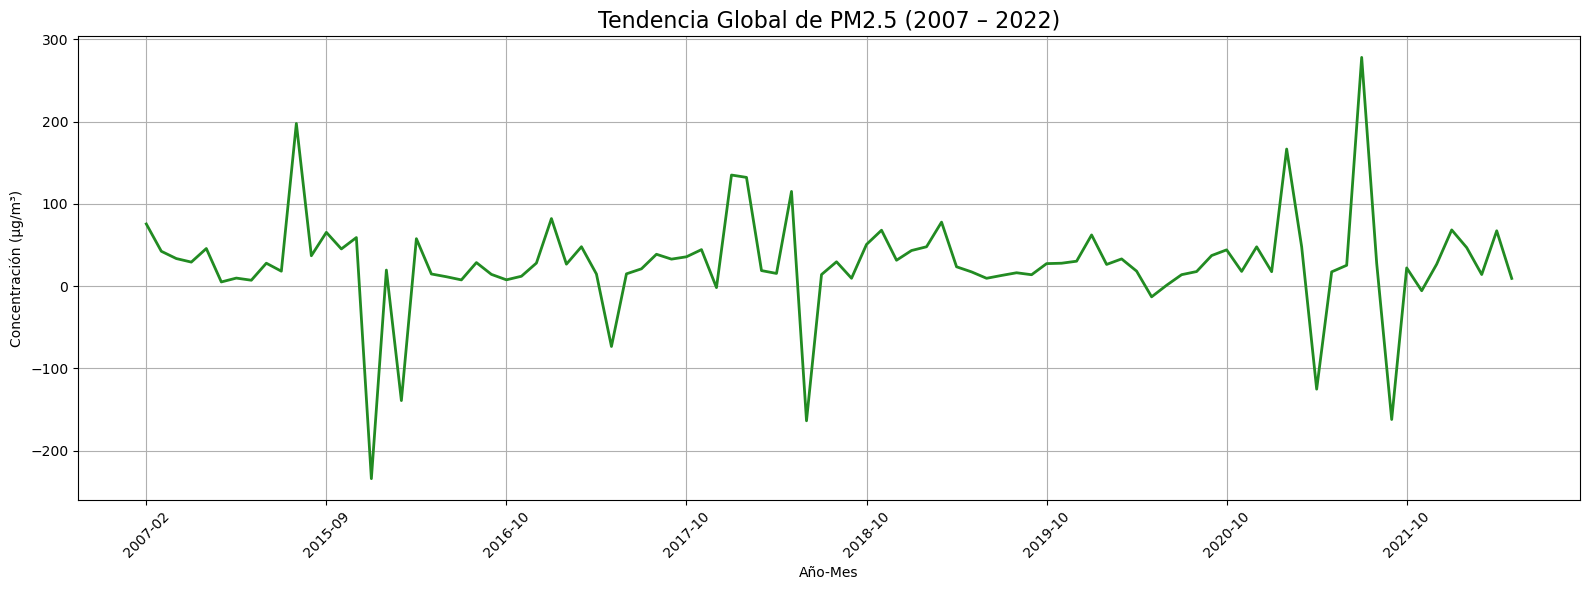

In [389]:
# Asegúrate de haber actualizado la consulta en tu código con el rango 2007–2022
df_pm25_global = client.query(query).to_dataframe()
df_pm25_global["timestamp"] = pd.to_datetime(df_pm25_global["timestamp"])
df_pm25_global["year_month"] = df_pm25_global["timestamp"].dt.to_period("M").astype(str)
df_pm25_global_grouped = (
    df_pm25_global
    .groupby("year_month")["value"]
    .mean()
    .reset_index()
)
plt.figure(figsize=(16, 6))
plt.plot(df_pm25_global_grouped["year_month"], df_pm25_global_grouped["value"], color='forestgreen', linewidth=2)
plt.title("Tendencia Global de PM2.5 (2007 – 2022)", fontsize=16)
plt.xlabel("Año-Mes")
plt.ylabel("Concentración (µg/m³)")
plt.xticks(ticks=df_pm25_global_grouped.index[::12], rotation=45)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Gráfico 4: Boxplot por país 

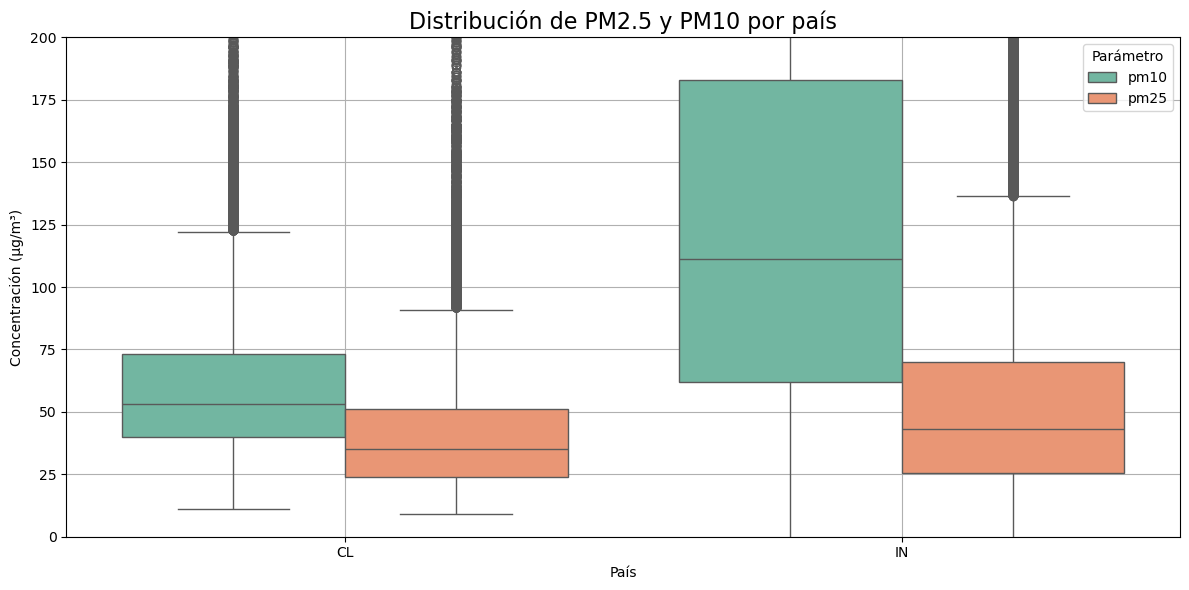

In [192]:
paises_box = ['CL', 'IN', 'NG', 'AU']

# Filtrar PM2.5 y PM10 
df_box = df[df["country"].isin(paises_box) & df["parameter"].isin(["pm25", "pm10"])].copy()

# Crear boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_box,
    x="country",
    y="value",
    hue="parameter",
    palette="Set2"
)

plt.title("Distribución de PM2.5 y PM10 por país", fontsize=16)
plt.xlabel("País")
plt.ylabel("Concentración (µg/m³)")
plt.ylim(0, 200)  
plt.grid(True)
plt.legend(title="Parámetro")
plt.tight_layout()
plt.show()


In [193]:
print(df_box["country"].value_counts())


country
IN    262582
CL     80689
Name: count, dtype: int64


In [194]:
print(df_box.groupby(["country", "parameter"]).size())


country  parameter
CL       pm10          38723
         pm25          41966
IN       pm10         128822
         pm25         133760
dtype: int64


In [195]:
top_paises = (
    df[df["parameter"].isin(["pm25", "pm10"])]
    .groupby("country")
    .size()
    .sort_values(ascending=False)
    .head(5)  
    .index.tolist()
)
df_box = df[df["country"].isin(top_paises) & df["parameter"].isin(["pm25", "pm10"])]
df_box

,country,city,location,parameter,value,unit,timestamp,year_month
0,CL,Tocopilla,Super Site,pm10,53.0,µg/m³,2022-05-13 22:00:00+00:00,2022-05
1,CL,Talagante,Talagante,pm10,110.0,µg/m³,2022-05-07 11:00:00+00:00,2022-05
2,CL,Talcahuano,Inpesca,pm10,150.0,µg/m³,2022-05-15 04:00:00+00:00,2022-05
3,CL,Chiguayante,Punteras,pm10,46.0,µg/m³,2022-05-10 10:00:00+00:00,2022-05
4,CL,Coyhaique,Coyhaique II,pm10,253.0,µg/m³,2022-05-16 07:00:00+00:00,2022-05
...,...,...,...,...,...,...,...,...
1030991,US,Peoria,PEORIA_J,pm25,23.3,µg/m³,2022-05-11 05:00:00+00:00,2022-05
1030992,US,Albany-Lebanon,Sweet Home - Fire De,pm25,8.1,µg/m³,2022-05-22 10:00:00+00:00,2022-05
1030993,US,Gettysburg,Arendtsville,pm25,5.3,µg/m³,2022-05-09 08:00:00+00:00,2022-05
1030994,US,Pittsburgh,Lawrenceville,pm25,6.2,µg/m³,2022-05-10 00:00:00+00:00,2022-05


### Por falta de datos en los paises seleccionados, seleccionaremos 4 regiones con más datos de Chile

In [196]:
# Filtramos solo Chile
df_chile = df[df["country"] == "CL"]

# Obtenemos las 4 ciudades con más registros
top_ciudades = (
    df_chile["city"]
    .value_counts()
    .head(4)
    .index.tolist()
)

print("Top 4 ciudades con más datos:", top_ciudades)


Top 4 ciudades con más datos: ['Coronel', 'Calama', 'Puchuncaví', 'Quintero']


In [197]:
# Filtramos para esas 4 ciudades y los parámetros PM2.5 y PM10
df_box_ciudades = df_chile[
    df_chile["city"].isin(top_ciudades) &
    df_chile["parameter"].isin(["pm25", "pm10"]) &
    (df_chile["value"] < 500)  # Limpiamos outliers extremos
]


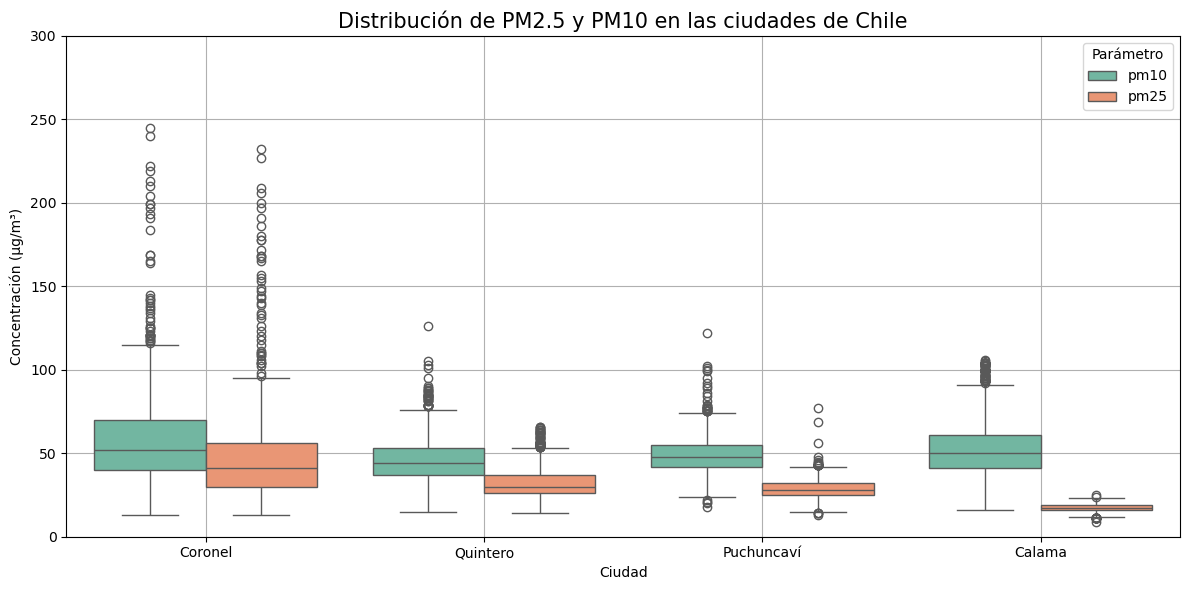

In [198]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_box_ciudades,
    x="city",
    y="value",
    hue="parameter",
    palette="Set2"
)

plt.title("Distribución de PM2.5 y PM10 en las ciudades de Chile", fontsize=15)
plt.xlabel("Ciudad")
plt.ylabel("Concentración (µg/m³)")
plt.grid(True)
plt.ylim(0, 300)
plt.legend(title="Parámetro")
plt.tight_layout()
plt.show()

# Gráfico 5: Distribución de contaminantes por mes y año en Chile

In [199]:
client = bigquery.Client()

query_chile = """
SELECT
  country,
  city,
  location,
  pollutant,
  value,
  unit,
  timestamp,
  latitude,
  longitude
FROM
  `bigquery-public-data.openaq.global_air_quality`
WHERE
  country = 'CL'
  AND pollutant IN ('pm25', 'pm10')
  AND timestamp BETWEEN TIMESTAMP('2020-01-01') AND TIMESTAMP('2023-12-31')
  AND latitude IS NOT NULL
  AND longitude IS NOT NULL
  AND value IS NOT NULL
"""

df_chile = client.query(query_chile).to_dataframe()

# Procesamiento temporal
df_chile["timestamp"] = pd.to_datetime(df_chile["timestamp"])
df_chile["year"] = df_chile["timestamp"].dt.year
df_chile["month"] = df_chile["timestamp"].dt.month
df_chile["year_month"] = df_chile["timestamp"].dt.to_period("M").astype(str)

df_chile.head()


/var/folders/l0/y6_kn2kj5ysb_90cx_wmwcvm0000gn/T/ipykernel_22785/1302853180.py:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_chile["year_month"] = df_chile["timestamp"].dt.to_period("M").astype(str)


,country,city,location,pollutant,value,unit,timestamp,latitude,longitude,year,month,year_month
0,CL,Tocopilla,Gobernación,pm10,42.0,µg/m³,2022-05-06 02:00:00+00:00,1.0,-22.093082,2022,5,2022-05
1,CL,Tocopilla,Gobernación,pm10,54.0,µg/m³,2022-05-23 19:00:00+00:00,1.0,-22.093082,2022,5,2022-05
2,CL,Tocopilla,Gobernación,pm10,42.0,µg/m³,2022-05-15 23:00:00+00:00,1.0,-22.093082,2022,5,2022-05
3,CL,Coronel,Coronel Sur,pm10,106.0,µg/m³,2022-05-12 04:00:00+00:00,1.0,-37.031702,2022,5,2022-05
4,CL,Coronel,Coronel Sur,pm10,37.0,µg/m³,2022-04-09 01:00:00+00:00,1.0,-37.031702,2022,4,2022-04


In [241]:
# Crear cliente
client = bigquery.Client()

# Consulta para obtener datos de PM2.5 y PM10 en Brasil
query_brasil = """
SELECT
  country,
  city,
  location,
  pollutant,
  value,
  unit,
  latitude,
  longitude,
  timestamp
FROM
  `bigquery-public-data.openaq.global_air_quality`
WHERE
  country = 'CL'
  AND pollutant IN ('pm25', 'pm10')
  AND value IS NOT NULL
  AND latitude IS NOT NULL
  AND longitude IS NOT NULL
"""

# Ejecutar consulta y cargar en DataFrame
df_chile = client.query(query_brasil).to_dataframe()

# Procesar timestamp
df_chile["timestamp"] = pd.to_datetime(df_chile["timestamp"])
df_chile["year"] = df_chile["timestamp"].dt.year
df_chile["month"] = df_chile["timestamp"].dt.month
df_chile["year_month"] = df_chile["timestamp"].dt.to_period("M").astype(str)
df_chile.head()


/var/folders/l0/y6_kn2kj5ysb_90cx_wmwcvm0000gn/T/ipykernel_22785/2725913347.py:33: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_chile["year_month"] = df_chile["timestamp"].dt.to_period("M").astype(str)


,country,city,location,pollutant,value,unit,latitude,longitude,timestamp,year,month,year_month
0,CL,Tocopilla,Gobernación,pm10,49.0,µg/m³,1.0,-22.093082,2022-05-12 23:00:00+00:00,2022,5,2022-05
1,CL,Quillota,La Palma,pm10,78.0,µg/m³,1.0,-32.891794,2022-05-19 00:00:00+00:00,2022,5,2022-05
2,CL,Tocopilla,Gobernación,pm10,53.0,µg/m³,1.0,-22.093082,2022-05-21 13:00:00+00:00,2022,5,2022-05
3,CL,Coronel,Coronel Sur,pm10,58.0,µg/m³,1.0,-37.031702,2022-04-28 06:00:00+00:00,2022,4,2022-04
4,CL,Quillota,La Palma,pm10,73.0,µg/m³,1.0,-32.891794,2022-05-17 13:00:00+00:00,2022,5,2022-05


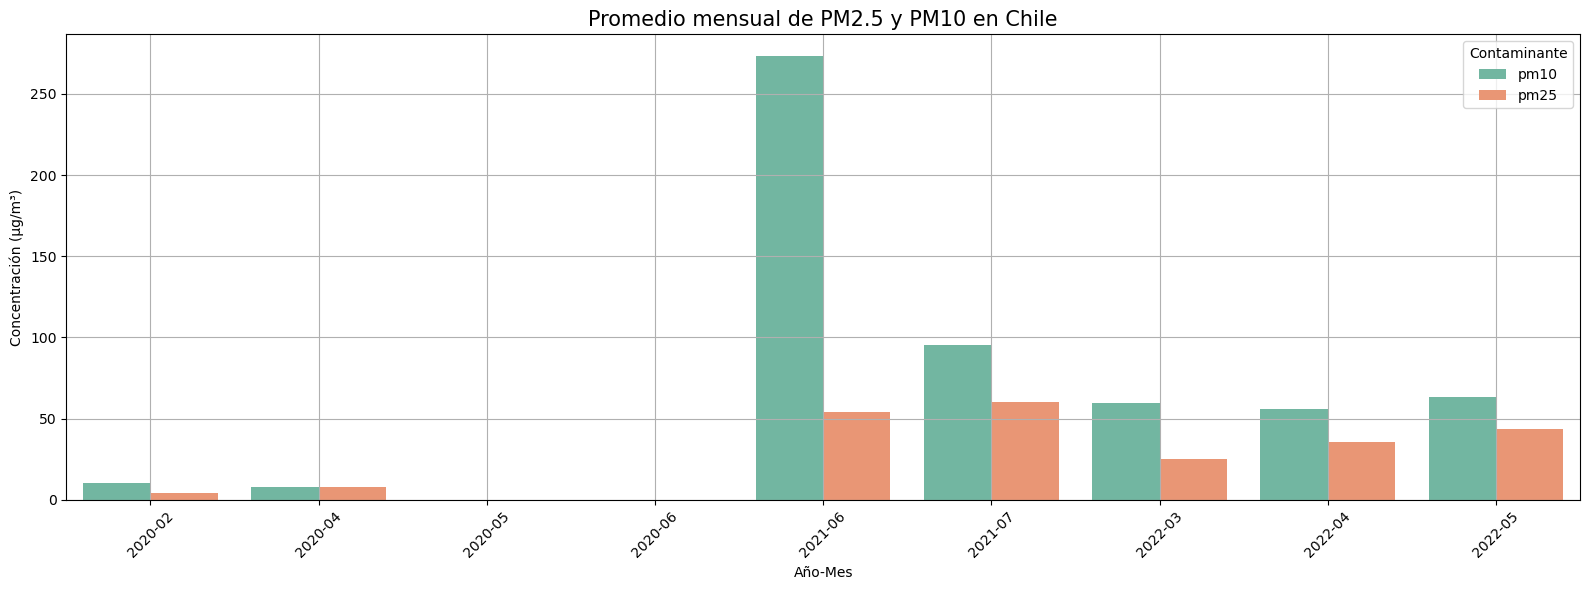

In [242]:

# Asegurarse que 'year' esté como número y filtrar últimos 3 años disponibles
años_disponibles = sorted(df_chile["year"].unique())[-3:]  # últimos 3 años disponibles
df_ultimos = df_chile[df_chile["year"].isin(años_disponibles)]

# Agrupar por año, mes y contaminante
df_mensual = (
    df_ultimos.groupby(["year", "month", "pollutant"])["value"]
    .mean()
    .reset_index()
)

# Convertir mes a nombre para mejor visualización
df_mensual["month"] = df_mensual["month"].apply(lambda x: f"{x:02}")
df_mensual["Mes"] = df_mensual["month"].map({
    "01": "Ene", "02": "Feb", "03": "Mar", "04": "Abr",
    "05": "May", "06": "Jun", "07": "Jul", "08": "Ago",
    "09": "Sep", "10": "Oct", "11": "Nov", "12": "Dic"
})

# Crear columna combinada para el eje x
df_mensual["AñoMes"] = df_mensual["year"].astype(str) + "-" + df_mensual["month"]

# Ordenar correctamente
df_mensual = df_mensual.sort_values(by="AñoMes")

# Plot
plt.figure(figsize=(16, 6))
sns.barplot(
    data=df_mensual,
    x="AñoMes",
    y="value",
    hue="pollutant",
    palette="Set2"
)
plt.title("Promedio mensual de PM2.5 y PM10 en Chile", fontsize=15)
plt.xlabel("Año-Mes")
plt.ylabel("Concentración (µg/m³)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Contaminante")
plt.tight_layout()
plt.show()


# Correlación entre PM2.5 y PM10 con Temperatura

In [378]:
query = """
SELECT 
  country,
  city,
  location,
  pollutant,
  value,
  unit,
  timestamp
FROM 
  `bigquery-public-data.openaq.global_air_quality`
WHERE 
  pollutant IN ('pm25', 'pm10')
  AND timestamp BETWEEN TIMESTAMP('2007-01-01') AND TIMESTAMP('2022-05-31')
"""


In [379]:
# Ejecutar la consulta
df_pm_global = client.query(query).to_dataframe()
df_pm_global["timestamp"] = pd.to_datetime(df_pm_global["timestamp"])
df_pm_global["year_month"] = df_pm_global["timestamp"].dt.to_period("M").astype(str)

# Agrupar por mes y contaminante
df_grouped = (
    df_pm_global
    .groupby(["year_month", "pollutant"])["value"]
    .mean()
    .reset_index()
)

# Pivot para crear columnas separadas para pm25 y pm10
df_pivot = df_grouped.pivot(index="year_month", columns="pollutant", values="value").dropna()


/var/folders/l0/y6_kn2kj5ysb_90cx_wmwcvm0000gn/T/ipykernel_22785/1227007056.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_pm_global["year_month"] = df_pm_global["timestamp"].dt.to_period("M").astype(str)


In [380]:
df_pivot

pollutant,pm10,pm25
year_month,,
2007-02,99.320000,51.770000
2007-04,57.295000,27.360000
2007-07,52.000000,14.910000
2007-09,42.895000,15.405000
2008-08,57.586000,33.724000
...,...,...
2022-01,90.615946,48.970342
2022-02,81.871493,14.271033
2022-03,26.400591,2.238725


In [381]:
query_temp = """
SELECT
  EXTRACT(YEAR FROM date) AS year,
  EXTRACT(MONTH FROM date) AS month,
  AVG(temp) AS avg_temp_celsius
FROM
  `bigquery-public-data.noaa_gsod.gsod*`
WHERE
  _TABLE_SUFFIX BETWEEN '2007' AND '2022'
  AND temp IS NOT NULL
GROUP BY
  year, month
ORDER BY
  year, month
"""


In [382]:
df_temp = client.query(query_temp).to_dataframe()
print(df_temp.columns)


Index(['year', 'month', 'avg_temp_celsius'], dtype='object')


In [383]:
# Eliminar filas con valores nulos en 'year' o 'month'
df_temp = df_temp.dropna(subset=["year", "month"])

# Convertir a int
df_temp["year"] = df_temp["year"].astype(int)
df_temp["month"] = df_temp["month"].astype(int)

# Crear columna 'year_month'
df_temp["year_month"] = pd.to_datetime(df_temp["year"].astype(str) + "-" + df_temp["month"].astype(str).str.zfill(2) + "-01")
# Si 'temp' está en Fahrenheit (verifica en tu query original), convierte a Celsius:
df_temp["avg_temp_celsius"] = (df_temp["avg_temp_celsius"] - 32) * 5 / 9

df_temp

,year,month,avg_temp_celsius,year_month
1,2020,1,5.487955,2020-01-01
2,2020,2,6.471982,2020-02-01
3,2020,3,9.309609,2020-03-01
4,2020,4,12.277902,2020-04-01
5,2020,5,15.996161,2020-05-01
6,2020,6,19.497196,2020-06-01
7,2020,7,20.933714,2020-07-01
8,2020,8,20.823580,2020-08-01
9,2020,9,18.002691,2020-09-01
10,2020,10,13.418901,2020-10-01


In [384]:
print(df_temp[["year", "month", "year_month"]].head())


   year  month year_month
1  2020      1 2020-01-01
2  2020      2 2020-02-01
3  2020      3 2020-03-01
4  2020      4 2020-04-01
5  2020      5 2020-05-01


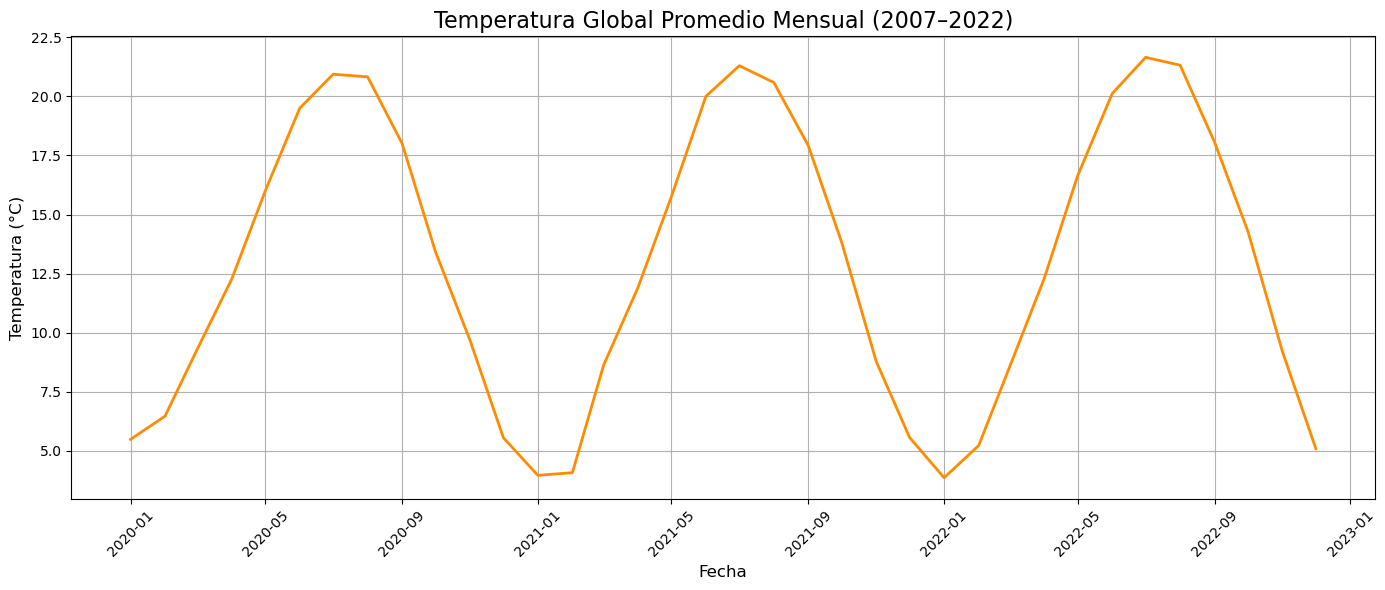

In [385]:
plt.figure(figsize=(14, 6))
plt.plot(df_temp["year_month"], df_temp["avg_temp_celsius"], color="darkorange", linewidth=2)
plt.title("Temperatura Global Promedio Mensual (2007–2022)", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Temperatura (°C)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


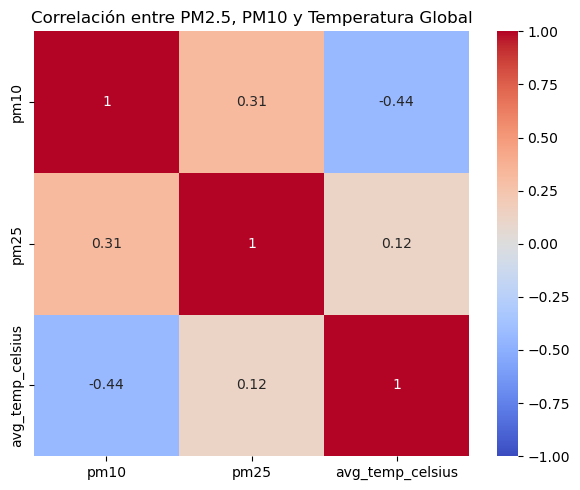

                      pm10      pm25  avg_temp_celsius
pm10              1.000000  0.312525         -0.435854
pm25              0.312525  1.000000          0.119680
avg_temp_celsius -0.435854  0.119680          1.000000


In [388]:
df_corr = df_merged[["pm10", "pm25", "avg_temp_celsius"]]

# Matriz de correlación
correlation_matrix = df_corr.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlación entre PM2.5, PM10 y Temperatura Global")
plt.tight_layout()
plt.show()
print(correlation_matrix)


# Análisis e interpretación

A la vista de los gráficos que comparan los niveles de PM2.5, PM10 y la temperatura, se aprecia en primer lugar que PM2.5 y PM10 guardan una relación bastante estrecha, coincidiendo sus peaks de concentración y demostrando que suelen responder a las mismas fuentes de emisión (tráfico, procesos industriales, quema de combustibles) o a condiciones que propician su acumulación (por ejemplo, episodios de inversión térmica o tormentas de polvo). Aunque sus magnitudes absolutas difieren (PM10 tiende a mostrar valores mayores por incluir partículas de mayor tamaño), las variaciones temporales de ambas series suelen ir a la par.

En segundo lugar, los gráficos reflejan cómo estas concentraciones se ven influenciadas por factores estacionales y meteorológicos. En periodos fríos, se puede observar un incremento notable de PM2.5 y PM10, en parte por la combinación de mayor uso de calefacción y menor dispersión atmosférica (inversiones térmicas). En zonas áridas o meses secos y cálidos, PM10 en especial tiende a aumentar debido a la resuspensión de polvo y a la disminución de la humedad relativa, mientras que PM2.5 puede presentar incrementos relacionados con procesos fotoquímicos que forman partículas finas a partir de contaminantes gaseosos.

Finalmente, la temperatura, cuando se cruza en los gráficos con PM2.5 y PM10, no muestra una correlación lineal uniforme en todos los casos, sino que su efecto varía según las condiciones locales (humedad, topografía, velocidad del viento). Sin embargo, de los gráficos se puede extrapolar que los niveles de contaminantes suelen elevarse en extremos térmicos: en el invierno frío, por la acumulación de contaminantes bajo inversiones, y en el verano o periodos muy calurosos y secos, por la formación de polvo y partículas secundarias. Así, los picos de PM2.5 y PM10 tienden a coincidir con escenarios de temperatura que dificultan la dispersión o favorecen la generación de contaminantes, lo que confirma la importancia de considerar las condiciones climáticas en conjunto al momento de interpretar los valores de estas partículas.